Lab ML for Data Science: Part I

In [1]:
import numpy as np
import pandas as pd
#import scipy
#import torch
#import torchvision
from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
quick_testing = True # all unnecessary plots and computationally intensive task will be skipped, so quick testing during development is ensured

# 1 Loading the Data, Preprocessing, Initial Data Analysis

The first step will consist of **downloading the dataset and converting it into numerical tables (e.g. numpy, arrays)**.
In practice, raw data is rarely directly usable as input to machine learning algorithms. In particular, there may be substantial heterogeneity between the different input features. Some features may be physical measurements, monetary measurements, while others may be category indicators or even non-numerical data such as text or images. Hence, a **preliminary filtering** of what is interesting for the analysis we would like to conduct is desirable.

In the context of the UCI wholesale dataset, one may, for example, want to base anomaly and cluster predictions on numerical data (annual spending per category) and drop meta-data such as Channel and the Region indicators or reserve it for an ulterior use. Once such a preliminary step has been taken, we have a standard dataset of size $N × d$ where $N$ is the number of instances (wholesale customers), $d$ is the number of spending categories, and each value in the table can be expressed in monetary unit.

To verify the range and distribution of these values, we can **generate some basic statistical visualizations** of the data. This includes **histograms** showing for each category the distribution of spendings, or **scatter plots** showing the correlation between different product categories. A common observation from such basic statistical analysis is that the distributions are heavy tailed, with many instances having rather small spendings, whereas a few may have spendings one or two orders of magnitude above. 

Any anomaly detection algorithm would systematically highlight those high spenders as anomalous and not make a distinction between spending little and not spending at all.
To address this issue, it can be useful to apply some **nonlinear transformation** to the data, for example, applying the log function to the features so that the distribution becomes compressed for large values and expanded for small values.

$x → log(x + θ)$

Here, we add a positive offset $θ$ in the logarithm so that zero spending $(x = 0)$ does not get mapped to $−∞$. You may experiment with different offsets, such as $θ = 1, θ = 10$ or $θ = 100$. To verify the effect of the transformation, you can **recompute the histograms and scatter plots** in transformed space and check visually whether the transformation had the desired result, e.g. whether the distribution look Gaussian-distributed.

# Loading and Understanding the data

In [3]:
data_pd = pd.read_csv('Wholesale customers data.csv')
data_pd.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
data_pd.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [5]:
data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


- the dataset has no missing value

In [6]:
data_pd.duplicated().sum()

0

- from such basic statistical analysis is that the distributions are heavy tailed, with many instances having rather small spendings, whereas a few may have spendings one or two orders of magnitude above.

In [7]:
data_scatter = data_pd.iloc[:,2:]  # remove channel and region
if not quick_testing:
    pd.plotting.scatter_matrix(data_scatter, figsize=(10, 10))
    plt.show()

In [8]:
def plotHistogramm():
    # Plot histograms for each product category
    plt.figure(figsize=(11, 5))

    for i, column in enumerate(data_scatter.columns):
        plt.subplot(2, 3, i+1)
        plt.hist(data_scatter[column], bins=20, color='skyblue', edgecolor='black')
        plt.title(column + ' Distribution')
        plt.xlabel('Spending')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

if not quick_testing:
    plotHistogramm()

In [9]:
data_scatter.corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


**Grocery and Detergents Paper are highly correlating. Grocery and Milk are correlating (but weaker with 73%)**

In [10]:
data_pd.groupby(["Region"]).count()

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Region,,,,,,,
1,77,77,77,77,77,77,77
2,47,47,47,47,47,47,47
3,316,316,316,316,316,316,316


In [11]:
data_pd.groupby(["Channel"]).count()

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,,,,,,,
1,298,298,298,298,298,298,298
2,142,142,142,142,142,142,142


**class imbalance of region and channel** 

# Preprocessing


### Log transformation to get gaussian distribution

In [ ]:
offset = 1e-10
data_log = data_pd.copy()
data_log.iloc[:, 2:] = data_log.iloc[:,2:].apply(lambda x:
                         np.log(x.astype(float) + offset))

In [13]:
data_log.dtypes

Channel               int64
Region                int64
Fresh               float64
Milk                float64
Grocery             float64
Frozen              float64
Detergents_Paper    float64
Delicassen          float64
dtype: object

In [14]:
data_log

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,2,3,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,2,3,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,1,3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,2,3,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525
...,...,...,...,...,...,...,...,...
435,1,3,10.299003,9.396903,9.682030,9.483036,5.204007,7.698029
436,1,3,10.577146,7.266129,6.638568,8.414052,4.532599,7.760467
437,2,3,9.584040,9.647821,10.317020,6.079933,9.605149,7.532088
438,1,3,9.238928,7.591357,7.710653,6.945051,5.123964,7.661527


In [15]:
data_log_scatter = data_log.iloc[:,2:]  # remove channel and region
if not quick_testing:
    pd.plotting.scatter_matrix(data_log_scatter, figsize=(10, 10))
    plt.show()

**Now the the features are gaussian distributed and we can continue with anomaly detection**

In [16]:
data_log_scatter.corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Fresh,1.000000,-0.019834,-0.132713,0.383996,-0.155871,0.255186
Milk,-0.019834,1.000000,0.758851,-0.055316,0.677942,0.337833
Grocery,-0.132713,0.758851,1.000000,-0.164524,0.796398,0.235728
Frozen,0.383996,-0.055316,-0.164524,1.000000,-0.211576,0.254718
Detergents_Paper,-0.155871,0.677942,0.796398,-0.211576,1.000000,0.166735
Delicassen,0.255186,0.337833,0.235728,0.254718,0.166735,1.000000


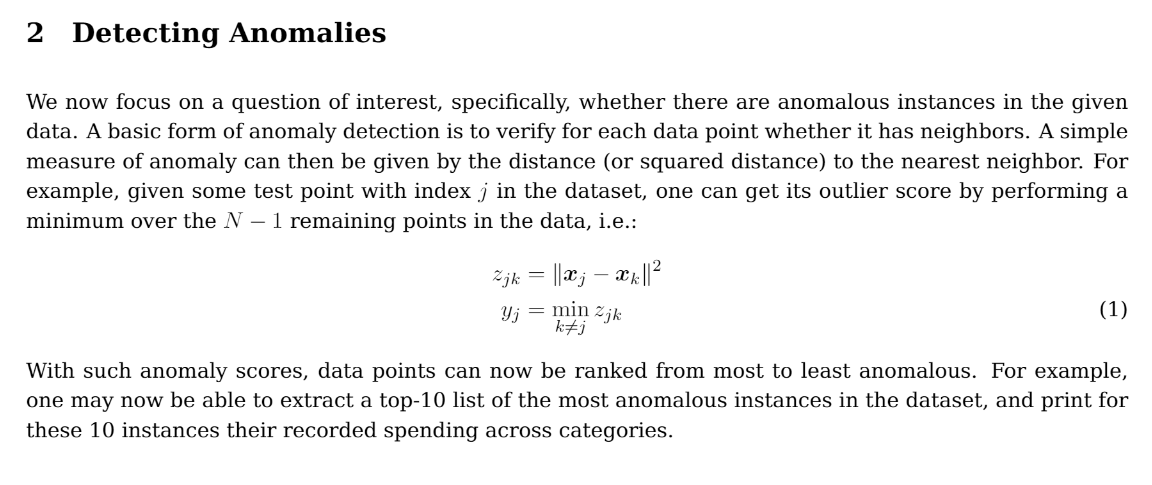

In [20]:
data_log_anomaly = data_log.copy()

In [21]:
data_log_anomaly["outlier_score"] = None 

In [52]:
all_distances = np.zeros((440, 440))
all_distances

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [53]:
def softMin(distances, gamma):
    score = None
    distances_gamma = [-gamma * x for x in distances]
    distances_gamma_exp = np.exp(distances_gamma)
    score = np.sum(distances_gamma_exp)
    score = score/(len(distances)) # it is already N-1 because in distances the distance with k==j is removed
    score = np.log(score)
    score = -(1/gamma) * score
    #print(score)

    return score

In [54]:
def calculate_outlier_score(df, soft_min, gamma): # soft_min is a bool that is used to decide whether to use naive min or softmin approach for anomaly detection
    global softMin
    epsilon = 1e-100
    highNumber = 1e20 # to avoid that distance between self data point is selected when searching the minimum and 0 would be the minimum so use high number
    distances_vectors = []
    distances_scalars = []
    outlier_score_index = df.columns.get_loc("outlier_score")

    for j in range(len(df)):
        for k in range(len(df)):
            if j ==k:
                distances_vectors.append([])
                distances_scalars.append(0)
            else:
                distances_vectors.append((df.iloc[j,2:8] - df.iloc[k,2:8]) **2)  #append x_j - x_k vectors
                distances_scalars.append(np.sum(distances_vectors[k]))  # z_jk := add all distances of the 6 features

        
        all_distances[j] = distances_scalars.copy()

        #print(distances_scalars)
        if soft_min:
            distances_scalars.remove(0) # because in softMin all elements are sumed up# remove 0
            df.iloc[j, outlier_score_index] = softMin(distances_scalars, gamma)
        else:
            distances_scalars.remove(0)
            df.iloc[j, outlier_score_index] =  np.min(distances_scalars)

        distances_vectors = []
        distances_scalars = []

#calculate_outlier_score(testdata, soft_min=False, gamma=1)
#testdata
calculate_outlier_score(data_log_anomaly, soft_min=True, gamma=0.1)
data_log_anomaly

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,outlier_score
0,2,3,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931,12.814728
1,2,3,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119,10.014894
2,2,3,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504,13.139614
3,1,3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853,10.197662
4,2,3,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525,11.861338
...,...,...,...,...,...,...,...,...,...
435,1,3,10.299003,9.396903,9.682030,9.483036,5.204007,7.698029,17.493686
436,1,3,10.577146,7.266129,6.638568,8.414052,4.532599,7.760467,15.370913
437,2,3,9.584040,9.647821,10.317020,6.079933,9.605149,7.532088,16.732074
438,1,3,9.238928,7.591357,7.710653,6.945051,5.123964,7.661527,10.443394


### 2.1.robust anomaly models


In practice, however, Eq. (1) may not identify top outliers in a way that is sufficiently reproducible. Imag-
ine, for example, a point xj whose nearest neighbor, call it xi is at a distance of 1 but the second nearest
neighbor is at a distance of 10. If the nearest point xi was not in the dataset (e.g. due to slight variations
in the data collection process), the outlierness score of xj would have changed drastically. An efficient
way of addressing this problem is to reconsider the notion of outlierness by considering a point to be an
outlier based on multiple neighbors. In other words, a point may still be an outlier even if (by accident)
some other point in the data shares roughly the same values.
Such a redefined notion of outlierness can be implemented by replacing the hard minimum in the
original equation by a soft minimum, i.e
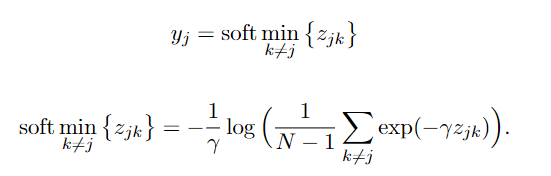

# 3. Getting Insights into Anomalies
In a data science setting, only detecting anomalies may be of limited interest. While it helps the scien-
tist to answer the basic question of whether there are anomalies in the data, one may wish for deeper
insights, for example, whether anomalies are under/over-represented among specific types of retailers,
or, for specific instances, which features (i.e. spending categories) contribute predominantly to instances
being anomalous.
3


## 3.1. Relation Between Anomalies and Meta-Data
We may be interested to know whether different subsets of the data (e.g. retailers of a specific type or in a
particular geographical locations) have more or less anomalies on average. Such insights can be obtained
by taking into consideration the meta-data. Your analysis could take the form of plotting the distribution of
anomaly scores on different subsets of data, where these subsets are determined based on the meta-data.
You may then look for differences in distribution.

In [59]:
data_log_anomaly.iloc[:,0].value_counts()

Channel
1    298
2    142
Name: count, dtype: int64

In [60]:
data_log_anomaly.iloc[:,1].value_counts()


Region
3    316
1     77
2     47
Name: count, dtype: int64

c:\Users\merty\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\merty\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\merty\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


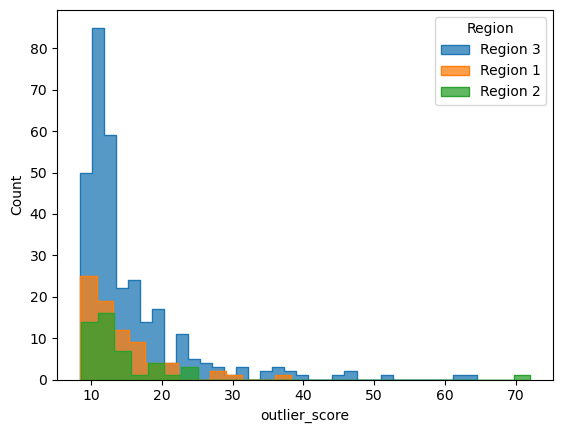

In [61]:
def plot_different_subsets(df):
    for i in df.iloc[:,1].value_counts().index:
        subset = df[df["Region"] == i]
        sns.histplot(subset["outlier_score"], label=f'Region {i}', element='step')
    plt.legend(title="Region")    

plot_different_subsets(data_log_anomaly)

In [63]:
data_log_anomaly["outlier_score"].quantile(.9)

22.298108896150946

c:\Users\merty\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\merty\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


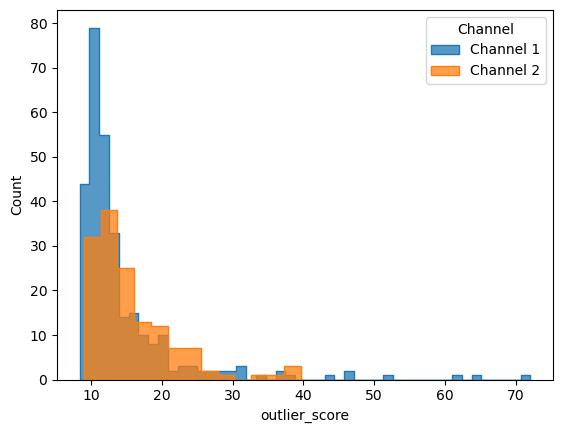

In [64]:
def plot_different_subsets(df):
    feature= "Channel"
    for i in df.iloc[:,0].value_counts().index:
        subset = df[df[feature] == i]
        sns.histplot(subset["outlier_score"], label=f'{feature} {i}', element='step')
    plt.legend(title=feature)    

plot_different_subsets(data_log_anomaly)

## 3.2 Indentifying Input Features that Drive Anomaly
Identifying relevant input features can be achieved using a set of techniques commonly referred to as
Explainable AI. We consider in particular the Layer-wise Relevance Propagation method (see [1] for an
overview). In the context of the anomaly detection models considered here, attribution of anomaly scores
to the input features can be achieved in two steps [2]: First, one identifies to what extent each data point
k other than j has contributed to the anomaly score of instance j:
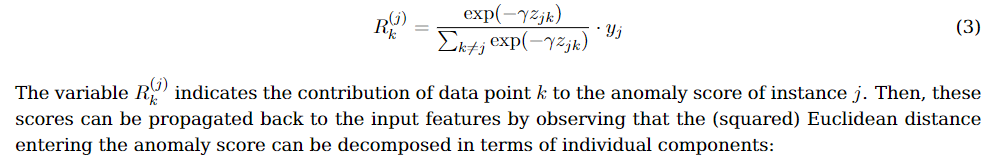

In [65]:
all_anamoly_scores = data_log_anomaly["outlier_score"]

In [90]:
gamma = 0.1
r_k_j = np.zeros(all_distances.shape)
for row,i in enumerate(all_distances):
    for column,j in enumerate(i):
        r_k_j[row][column] = np.exp(-gamma*j)/(np.sum(np.exp(-gamma*i))-np.exp(-gamma*j))*all_anamoly_scores[row]
r_k_j

array([[0.10514326, 0.06378342, 0.04029328, ..., 0.05912114, 0.02473976,
        0.01219747],
       [0.03770415, 0.06210451, 0.04889565, ..., 0.03308699, 0.0152642 ,
        0.00231867],
       [0.04267205, 0.08764005, 0.11136898, ..., 0.04106872, 0.02313763,
        0.00102145],
       ...,
       [0.11401713, 0.1079166 , 0.07473122, ..., 0.20311874, 0.00819451,
        0.00298603],
       [0.01592623, 0.0166108 , 0.01406587, ..., 0.00274183, 0.06759708,
        0.00593063],
       [0.06151955, 0.01973822, 0.00485753, ..., 0.00781435, 0.04643399,
        0.53725974]])

In [89]:
all_anamoly_scores.min()

8.35088406137958

In [91]:
r_k_j.min()

6.575450063448237e-11

In [92]:
def rij(df):
    r_i_j = np.zeros((440,6))
    distances_features = np.zeros((440)) # store the values to be summed

   
    for j in range(len(df)):
        for i in range(6): # i=6 features
            for k in range(len(df)):
                if j!=k:
                     # calculate 439 squared difference of i-th feature / squared Euclidian distance of all features * R_k_j
                    distances_features[k] = (df.iloc[k,i] - df.iloc[j,i]) **2  /  all_distances[j][k]  *  r_k_j[j][k]
            r_i_j[j][i] = np.sum(distances_features)
            distances_features = np.zeros((440)) # reset
    
    return r_i_j

r_i_j = rij(data_log_anomaly)

In [108]:
r_i_j[0]

array([0.90356326, 1.36776257, 1.95317168, 1.50169067, 0.87257478,
       5.04330267])

In [109]:
r_i_j[0].sum()

11.642065627245117

In [106]:
all_anamoly_scores[0]

12.814727911933323

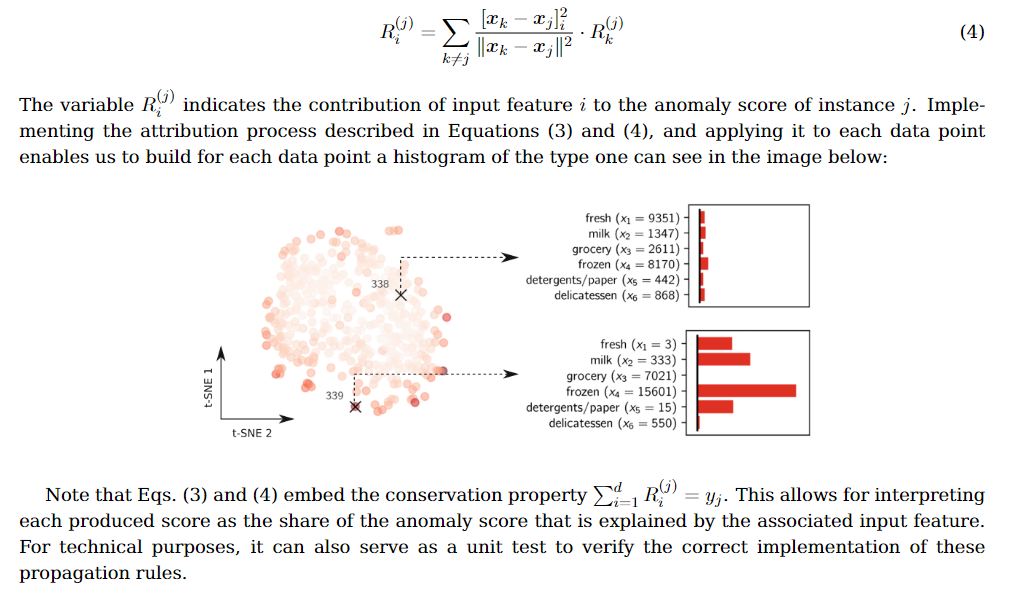

In [98]:
data_log_anomaly.columns[2:8]

Index(['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen'], dtype='object')

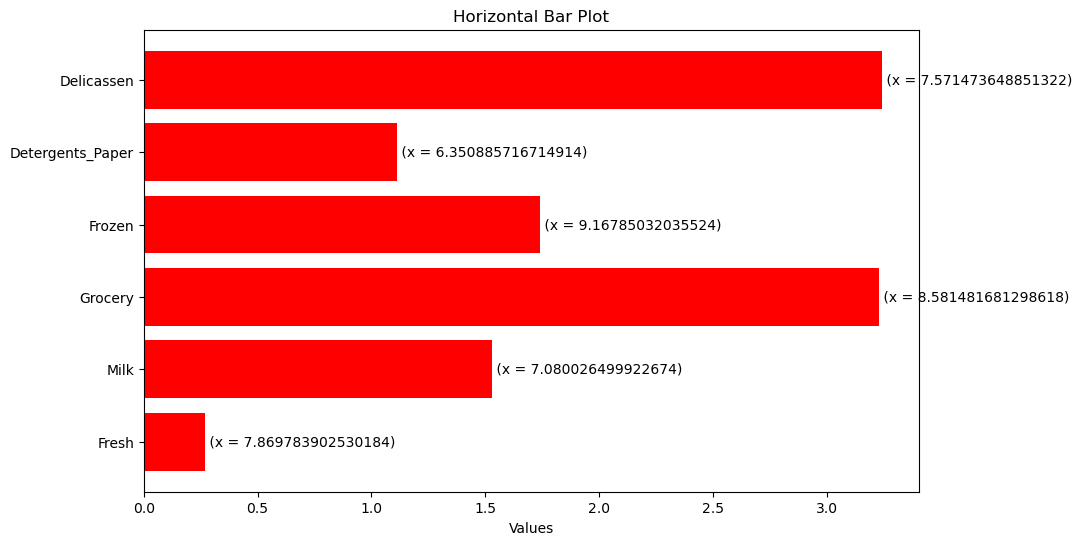

In [104]:
def plot_feature_contribution(df, instance):
    categories = data_log_anomaly.columns[2:8]
    # Creating the bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(categories, r_i_j[instance], color='red')
    
    # Adding text labels to the bars
    for bar, value in zip(bars, df.iloc[instance,2:8]):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f' (x = {value})', va='center')
    
    plt.xlabel('Values')
    plt.title('Horizontal Bar Plot')
    plt.show()

plot_feature_contribution(data_log_anomaly, 339)